In [1]:
#Libraries
import re
import numpy as np
import pandas as pd

file_name='TTP Problems small.txt'



#global vars
global dict_constants #constanst of current problem
global nodes_df
global items_df


def read_data(file_name):
    global dict_constants, nodes_df, items_df

    dict_constants={}

    #read txt file on absolute path
    with open(f"./{file_name}") as raw:
        data = raw.read()
        nodes_pos=data.split('ITEMS SECTION')[0]
        items_vals = data.split('ITEMS SECTION')[1]

        #CONSTANTS
        for global_features in nodes_pos.split('\n')[2:8]:
            temp = global_features.split('\t')
            var_name = temp[0].replace((':'),' ').strip()
            var_val = temp[1]
            dict_constants[var_name] = float(var_val)

        #NODES POSTIONS
        all_nodes_list = []
        for vals in nodes_pos.split('\n')[10:-1]:
            temp = vals.split('\t')
            temp = [float(t) for t in temp]
            all_nodes_list.append(temp)

        nodes_df = pd.DataFrame(all_nodes_list, columns=['node_index', 'x_coor', 'y_coor'])
        nodes_df['node_index'] = nodes_df['node_index'].astype('int')


        #ITEMS
        all_items_list = []
        for vals in items_vals.split('\n')[1:-1]:
            temp = vals.split('\t')
            temp = [float(t) for t in temp]
            all_items_list.append(temp)

        items_df = pd.DataFrame(all_items_list, columns=['item_index','profit','weight','assigned_node'])
        items_df['item_index']= items_df['item_index'].astype('int')
        items_df['assigned_node'] = items_df['assigned_node'].astype('int')

    #close file
    raw.close()

def generate_random_initial_population_knappsack(pop_size,dimension):
    global number_fitness_eval #set global var

    #start at zero evals
    number_fitness_eval=0

    #population list
    population = []

    #use numpy random int between 0-1 to create solutions with size of number of bags [0,1,0,0,1.....] to 100
    for i in range(0, pop_size):
        actual_sol = np.random.randint(2, size=int(dimension))
        population.append(actual_sol)

    return population



read_data(file_name)

In [2]:
print(items_df)
print(nodes_df)
print(dict_constants)

     item_index  profit  weight  assigned_node
0             1     1.0  1008.0              2
1             2   896.0  1006.0              3
2             3   367.0  1006.0              4
3             4   690.0  1001.0              5
4             5   613.0  1006.0              6
..          ...     ...     ...            ...
489        1210   132.0  1007.0             95
490        1211    20.0  1008.0             96
491        1212   975.0  1002.0             97
492        1213    29.0  1006.0             98
493        1214   681.0  1004.0             99

[494 rows x 4 columns]
    node_index  x_coor  y_coor
0            1   288.0   149.0
1            2   288.0   129.0
2            3   270.0   133.0
3            4   256.0   141.0
4            5   256.0   157.0
..         ...     ...     ...
95          96    16.0    17.0
96          97    24.0    17.0
97          98    32.0    17.0
98          99    44.0    11.0
99         100    56.0     9.0

[100 rows x 3 columns]
{'DIMENSION': 28

In [3]:
def generate_random(item, node):#A sequence of random numbers generated for the purpose of testing the program
    import random
    from sklearn.utils import shuffle
    
    length = len(item)
    
    random_item = [random.randint(0, 1) for i in range(length)]
    
    print(random_item)
    
    #print(node['node_index'])
    node_index = node['node_index'].copy()
    #print(type(node_index))
    #node_index = node_index.reset_index()
    random_node = shuffle(node_index)
    #print(random_node)
    random_node = random_node.reset_index()
    
    random_node = random_node.drop(columns = ['index'])
    print(random_node)
    
    return(random_item, random_node)

In [4]:
def eul_dis(node1, node2):#Calculation of Euclidean distance
    #print(node1['x_coor'].iloc[0])
    #print(node1)
    dis = (((node1['x_coor'].iloc[0] - node2['x_coor'].iloc[0]) ** 2) + ((node1['y_coor'].iloc[0] - node2['y_coor'].iloc[0]) ** 2)) ** 0.5
    #print(dis,'dis')
    return(dis)

In [5]:
def cul_dis(node, n_df):#Calculate the length of each path
    dis_df = pd.DataFrame(np.zeros(len(node['node_index'])))
    #print(dis_df)
    #print(n_df.iloc[7])
    j = 0
    for i in range(len(node['node_index'])):
        #print(node['node_index'][i])
        if i != len((node['node_index'])) - 1:
            #print(i)
            node1 = n_df.loc[n_df['node_index'] == node['node_index'][i]]
            node2 = n_df.loc[n_df['node_index'] == node['node_index'][i+1]]
            dis_df[0].iloc[j] = eul_dis(node1, node2)
            #print(dis_df)
            j += 1
        else:
            node1 = n_df.loc[n_df['node_index'] == node['node_index'][i]]
            node2 = n_df.loc[n_df['node_index'] == node['node_index'][0]]
            dis_df[0].iloc[j] = eul_dis(node1, node2)
            j += 1
    #print(dis_df)
    return(dis_df)


In [6]:
def cul_weight_speed_profit(node, new_i_df, min_sp, max_sp, capacity):#Calculate the weight, profit and speed after passing each point
    wei_df = pd.DataFrame(np.zeros(len(node['node_index'])))
    pro_df = pd.DataFrame(np.zeros(len(node['node_index'])))
    node['weight'] = wei_df
    node['profit'] = pro_df
    
    for i in range(len(new_i_df)):
        
        node_index = node[node['node_index'] == new_i_df['assigned_node'].iloc[i]].index[0]
        
        node['weight'][node_index] += new_i_df['weight'].iloc[i]
        node['profit'][node_index] += new_i_df['profit'].iloc[i]
    
    node['cumsum_w'] = node['weight'].cumsum(axis = 0)
    node['cumsum_p'] = node['profit'].cumsum(axis = 0)
    node['speed'] = node['cumsum_w'].map(lambda x: max_sp - (x / capacity * (max_sp - min_sp)))
    #print(node)
    return(node)

In [13]:
def cul_time(node, n_df, item, i_df, min_sp, max_sp, capacity):#Calculate the time traveled on each road
    #print(node)
    #print(n_df)
    #print(item)
    #print(i_df)
    print(min_sp, max_sp, capacity)
    di_df = cul_dis(node, n_df)
    node['distance'] = di_df
    i_df['item'] = item
    new_i_df = i_df.copy()
    new_i_df = new_i_df[new_i_df['item'] != 0]
    print(new_i_df)
    node = cul_weight_speed_profit(node, new_i_df, min_sp, max_sp, capacity)
    node['time'] = node.apply(lambda x: x['distance'] / x['speed'], axis = 1)
    print(node)
    return(node)


In [8]:
def cul_fitness(node):#Calculate the fitness.
    
    #Normalize time and profit to reduce errors caused by data size gaps.
    time_max = node['time'].max()
    time_min = node['time'].min()
    node['normal_time'] = node['time'].map(lambda x: (x - time_min) / (time_max - time_min))
    pro_max = node['profit'].max()
    pro_min = node['profit'].min()
    node['normal_profit'] = node['profit'].map(lambda x: (x - pro_min) / (pro_max - pro_min))
    
    #Fitness at each point is the result of profit minus time.
    node['fitness'] = node.apply(lambda x: x['normal_profit'] - x['normal_time'], axis = 1)
    print(node)
    
    #Total fitness is the sum of all individual fitness.
    total_fitness = node['fitness'].sum()
    print(total_fitness, 'total_fitness')
    
    #Start calculating the total fitness for each point and then normalize it to be able to compare it to the original data to see how effective fitness is
    node['cumsum_f'] = node['fitness'].cumsum(axis = 0)
    cu_f_max = node['cumsum_f'].max()
    cu_f_min = node['cumsum_f'].min()
    node['normal_c_f'] = node['cumsum_f'].map(lambda x: (x - cu_f_min) / (cu_f_max - cu_f_min))
    return(node, total_fitness)


In [9]:
def plot_fig(node):
    
    #n_node = node[['normal_time', 'normal_profit', 'fitness']].copy()
    t_f_node = node[['normal_time', 'normal_c_f']].copy()
    t_f_node.plot()
    p_f_node = node[['normal_profit', 'normal_c_f']].copy()
    p_f_node.plot()


[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_12644\2090449666.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node['weight'][node_index] += new_i_df['weight'].iloc[i]
C:\Users\lenovo\AppData\Local\Temp\ipykernel_12644\2090449666.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node['profit'][node_index] += new_i_df['profit'].iloc[i]


    node_index    distance  weight  profit  cumsum_w  cumsum_p     speed  \
0           49   28.844410  3017.0  1104.0    3017.0    1104.0  0.995737   
1           41   97.406365  2013.0   702.0    5030.0    1806.0  0.992893   
2           22  108.000000  1009.0   247.0    6039.0    2053.0  0.991468   
3           50   68.000000  2007.0  1223.0    8046.0    3276.0  0.988632   
4           69   49.477268  3020.0  2609.0   11066.0    5885.0  0.984365   
..         ...         ...     ...     ...       ...       ...       ...   
95          29   72.443081  2008.0  1163.0  235107.0  111906.0  0.667829   
96          14  156.000000  3015.0  1997.0  238122.0  113903.0  0.663569   
97          51   24.000000  2016.0   992.0  240138.0  114895.0  0.660721   
98          37  129.243955  4018.0  1579.0  244156.0  116474.0  0.655044   
99          77  116.481758  4014.0  2737.0  248170.0  119211.0  0.649373   

          time  
0    28.967888  
1    98.103552  
2   108.929408  
3    68.781899  
4 

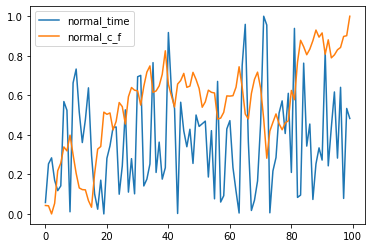

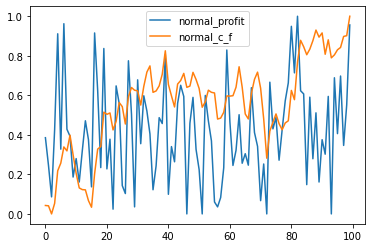

In [14]:
def main():
    random_item, random_node = generate_random(items_df, nodes_df)
    di_df = cul_dis(random_node, nodes_df)
    print(di_df)
    new_node = cul_time(random_node, nodes_df, random_item, items_df,  dict_constants['MIN SPEED'], dict_constants['MAX SPEED'], dict_constants['CAPACITY OF KNAPSACK'])
    new_node, total_fitness = cul_fitness(new_node)
    plot_fig(new_node)
    
if __name__ == "__main__":
    main()